In [98]:
%matplotlib inline
#Imports required to run

import pynbody
SimArray = pynbody.array.SimArray
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate

#Typical plot parameters that make for pretty plots
mpl.rcParams['figure.figsize'] = (9,8)
mpl.rcParams['font.size'] = 25.0

## for Palatino and other serif fonts use:
mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
mpl.rc('text', usetex=True)

In [99]:
# Load in data
archiveName = "/astro/users/dflemin3/Desktop/sims/k38_2016_sims/k38_50000/k38_snap_archive.npz"

#Load from archive
archive = np.load(archiveName)

radius = archive["r"]
sigma = archive["sigma"]
Hr = archive["Hr"]
time = archive["time"]

# Replace nan with mean
mask = np.isnan(Hr)
Hr[mask] = np.nanmean(Hr)

In [100]:
# Come up with fit equation
def lookup(t):
    TOL = 1.0e-5
    return np.argmin(np.fabs(time-t))

def sigma_fn(t):
    return sigma[lookup(t)]

def r_fn(t):
    return radius[lookup(t)]

def Hr_fn(t):
    return Hr[lookup(t)]

In [101]:
def deda(w, t, p):
    # Artymowicz + Lubow 2000 a_dot/a (eqn 3) and e_dot (eqn 4)
    # Assumes l = 1, m = 2 for 1:3 EOLR
    # Written a la scipy coupled spring example
    # Note: make "constants" like sigma a function of time for the integration
    # Need to make this some spline interpolation (2d for sigma)
    
    # Extract params
    # p = [r, sigma, alpha, Hr, Mbin, mu]
    r = p[0]
    sigma = p[1]
    alpha = p[2]
    Hr = p[3]
    Mbin = p[4]
    mu = p[5]
    
    # Define constants
    G = 4.0*np.pi*np.pi # in AU^3 yr^-2 M_sol^-1
    
    # Params to integrate...semimajor axis and eccentricity
    a = w[0]
    e = w[1]
    
    # Compute adot
    omega = np.sqrt(G*Mbin/np.power(a,3.))
    adot = -3.0*alpha*a*a*omega
    adot /= (np.sqrt(1.0 - e*e)*mu*(1.0 - mu))
    
    # Compute qd*H/r ^2, integrate it over r
    qd = np.pi*Hr(t)*Hr(t)*r(t)*sigma(t)/Mbin
    qd = np.trapz(qd,r(t))
        
    adot *= qd
    
    # Compute edot with Roedig et al 2012 and Dermine et al 2013 cap
    if e >= 0.7:
        edot = 0.0
    else:
        edot = (1.0 - e*e)/e
        edot *= (0.5 - 1./np.sqrt(1. - e*e))
        edot *= (adot/a)
    
    return [adot, edot]

In [102]:
# Try to integrate it

# Initial conditions

# Parameters
alpha = 0.01 # 0.016 for N_gas = 200,000, 0.02 for N_gas = 100,000
mu = 0.208
Hr = Hr
Mbin = 0.949 + 0.249
r = radius
sigma = sigma

p = [r_fn, sigma_fn, alpha, Hr_fn, Mbin, mu]

# Integration parameters
a0 = 0.1469
e0 = 0.1032

w0 = [a0, e0]

# Tolerances
abserr = 1.0e-10
relerr = 1.0e-10

# Call the ODE solver
wsol = sp.integrate.odeint(deda, w0, time, args=(p,),
                          atol = abserr, rtol = relerr)

In [103]:
wsol[-1]

array([ 0.14559463,  0.1399125 ])

In [104]:
orbElems = archive["orbElems"]
a = orbElems[:,1]
e = orbElems[:,0]

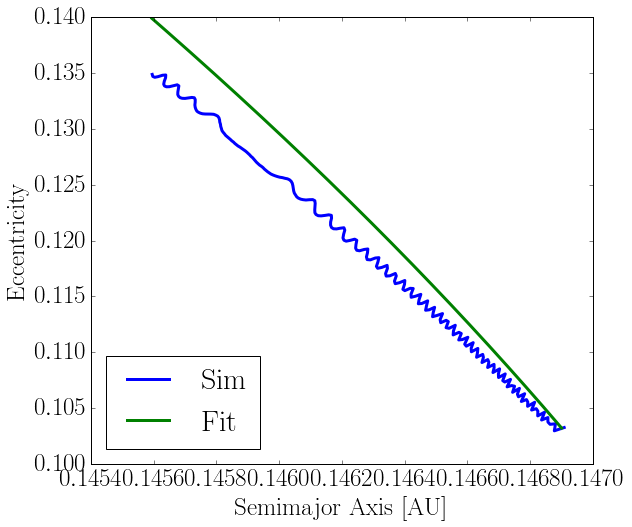

In [105]:
fig, ax = plt.subplots()

ax.plot(a,e,lw=3,label="Sim")
ax.plot(wsol[:,0],wsol[:,1],lw=3,label="Fit")

ax.set_xlabel("Semimajor Axis [AU]")
ax.set_ylabel("Eccentricity")
ax.legend(loc="lower left")

In [109]:
def deda_armitage(a,e,c=-4.4):
    return e[0] + c*np.log(a/a[0])

In [132]:
# Load in data
archiveName = "/astro/users/dflemin3/Desktop/sims/k38_2016_sims/k38_e_0.25_final/k38_snap_archive.npz"

#Load from archive
archive = np.load(archiveName)

orbElems = archive["orbElems"]

a_25 = orbElems[:,1]
e_25 = orbElems[:,0]

# Load in data
archiveName = "/astro/users/dflemin3/Desktop/sims/k38_2016_sims/k38_e_0.1032_final/k38_snap_archive.npz"

#Load from archive
archive = np.load(archiveName)

orbElems = archive["orbElems"]

a_1032 = orbElems[:,1]
e_1032 = orbElems[:,0]

# Load in data
archiveName = "/astro/users/dflemin3/Desktop/sims/k38_2016_sims/k38_e_0.05_final/k38_snap_archive.npz"

#Load from archive
archive = np.load(archiveName)

orbElems = archive["orbElems"]

a_05 = orbElems[:,1]
e_05 = orbElems[:,0]

# Load in data
archiveName = "/astro/users/dflemin3/Desktop/sims/k38_2016_sims/k38_200000/k38_snap_archive.npz"

#Load from archive
archive = np.load(archiveName)

orbElems = archive["orbElems"]

a_200000 = orbElems[:,1]
e_200000 = orbElems[:,0]

(0.1449, 0.14695)

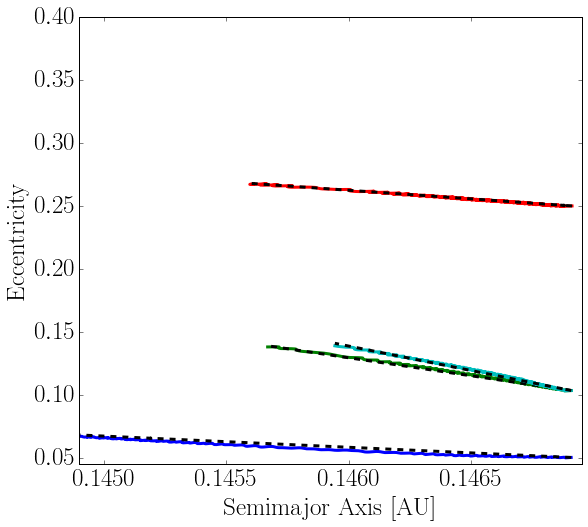

In [139]:
fig, ax = plt.subplots()

ax.plot(a_05,e_05,lw=3,label="$e = 0.05$")
ax.plot(a_05,deda_armitage(a_05,e_05,c=-1.3),lw=3,ls="--",color="black",label="Fit")

ax.plot(a_1032,e_1032,lw=3,label="$e = 0.1032$")
ax.plot(a_1032,deda_armitage(a_1032,e_1032,c=-4.2),lw=3,ls="--",color="black")

ax.plot(a_25,e_25,lw=3,label="$e = 0.25$")
ax.plot(a_25,deda_armitage(a_25,e_25,c=-2),lw=3,ls="--",color="black")

ax.plot(a_200000,e_200000,lw=3,label="$e = 0.1032, N_{gas} = 200000$")
ax.plot(a_200000,deda_armitage(a_200000,e_200000,c=-5.7),lw=3,ls="--",color="black")

ax.set_ylabel("Eccentricity")
ax.set_xlabel("Semimajor Axis [AU]")

ax.set_ylim(0.045, 0.4)
ax.set_xlim(0.1449,0.14695)